In [165]:
class State:
    def __init__(self, x, y, velx, vely, x_bounds=(None, None), y_bounds=(None, None), velx_bounds=(None, None), vely_bounds=(None, None)):
        self.x = x
        self.y = y
        self.velx = velx
        self.vely = vely

        self.x_bounds = x_bounds
        self.y_bounds = y_bounds
        self.velx_bounds = velx_bounds
        self.vely_bounds = vely_bounds

    def update(self, accx, accy, dT):
        """Kinematics"""
        self.velx += accx * dT
        self.vely += accy * dT
        self.x += self.velx * dT
        self.y += self.vely * dT

    def copy(self):
        return State(self.x, self.y, self.velx, self.vely, self.x_bounds, self.y_bounds, self.velx_bounds, self.vely_bounds)

    def updated_state(self, inputs, dT):
        new_state = State(self.x, self.y, self.velx, self.vely, self.x_bounds, self.y_bounds, self.velx_bounds, self.vely_bounds)
        for i in inputs:
            new_state.update(i[0], i[1], dT)

        return new_state

    def raw_state(self):
        return [self.x, self.y, self.velx, self.vely]

    def check_bounds(self):
        if self.x_bounds[0] != None:
            if self.x < self.x_bounds[0]:
                return False
        if self.x_bounds[1] != None:
            if self.x > self.x_bounds[1]:
                return False
        if self.y_bounds[0] != None:
            if self.y < self.y_bounds[0]:
                return False
        if self.y_bounds[1] != None:
            if self.y > self.y_bounds[1]:
                return False

        if self.velx_bounds[0] != None:
            if self.velx < self.velx_bounds[0]:
                return False
        if self.velx_bounds[1] != None:
            if self.velx > self.velx_bounds[1]:
                return False
        if self.vely_bounds[0] != None:
            if self.vely < self.vely_bounds[0]:
                return False
        if self.vely_bounds[1] != None:
            if self.vely > self.vely_bounds[1]:
                return False

        return True

    def check_obstacles(self, obstacles):
        for i in obstacles:
            distance = ((self.x - obstacle[0])**2 + (self.y - obstacle[1])**2)**.5
            if distance < obstacle[2]:
                return 1

        return 0

In [166]:
from scipy.optimize import minimize, NonlinearConstraint

class Optimizer:
    def __init__(self, initial_state, waypoints, dT, per_state_cost_function, final_state_cost_function, goal, obstacles, input_bounds, additional_constraints=lambda x: 0):
        self.state = initial_state
        self.waypoints = waypoints
        self.state_cost = per_state_cost_function
        self.fstate_cost = final_state_cost_function
        self.obstacles = obstacles
        self.goal = goal
        self.dT = dT
        self.additional_constraints = additional_constraints
        self.input_bounds = input_bounds

    def cost(self, x):
        state = self.state.copy()
        x = np.reshape(x, (-1, 2))

        cost = 0
        for i in x:
            state.update(i[0], i[1], self.dT)

            cost += self.state_cost(state, self.obstacles, self.goal)
            
        cost += self.state_cost(state, self.obstacles, self.goal) + self.fstate_cost(state, self.goal)

        return cost

    def constraints(self, x):
        state = self.state.copy()
        x = np.reshape(x, (-1, 2))

        cost = 0
        for i in x:
            state.update(i[0], i[1], self.dT)
            # cost += (not state.check_bounds() * 1)
            cost += state.check_obstacles(self.obstacles)

        return cost

    def calculate_optimal_input(self, initial_guess, N, dT):
        # N actions
        # N+1 states
        actions = np.array( [initial_guess for i in range(N)] )
        actions = actions.flatten()
        
        bounds = [ self.input_bounds for i in range(N * 2) ]
        
        # Minimize the cost function
        result = minimize(self.cost, actions, bounds=bounds)
        
        optimal_inputs = result.x
        return optimal_inputs

    

In [177]:
def dist(a, b):
    return ((b[0] - a.x) ** 2 + (b[1] - a.y) ** 2)**.5

def per_state_cost_function(state, obstacles, goal):
    cost = 0

    x_dist = (goal.x - state.x) ** 2
    y_dist = (goal.y - state.y) ** 2

    cost += (x_dist + y_dist) ** .5

    if state.velx_bounds[1] is not None and state.velx > state.velx_bounds[1]:
        cost += 100 * state.velx - state.velx_bounds[1]
    if state.velx_bounds[0] is not None and state.velx < state.velx_bounds[0]:
        cost += 100 * state.velx_bounds[0] - state.velx
    if state.vely_bounds[1] is not None and state.vely > state.vely_bounds[1]:
        cost += 100 * state.velx - state.velx_bounds[1]
    if state.vely_bounds[0] is not None and state.vely < state.vely_bounds[0]:
        cost += 100 * state.vely_bounds[0] - state.vely

    for obstacle in obstacles:
        if dist(state, obstacle) <= obstacle[2]:
            cost += 100000000 * (obstacle[2] - dist(state, obstacle))

    return cost

def final_state_cost_function(state, goal):
    x_dist = (goal.x - state.x) ** 2
    y_dist = (goal.y - state.y) ** 2
    vx_dist = (goal.velx - state.velx) ** 2
    vy_dist = (goal.vely - state.vely) ** 2

    return (x_dist + y_dist + vx_dist + vy_dist) * 1000
    

In [181]:
initial_state = State(0, 0, 0, 0, velx_bounds=(-10, 10), vely_bounds=(-10, 10))
goal_state = State(10, 10, 0, 0, velx_bounds=(-10, 10), vely_bounds=(-10, 10))

obstacles = [[2.5, 2.5, 1], [5.0, 5.0, 1], [7.5, 7.5, 1]]
waypoints = [[2, 5], [10, 10]]
dT = .1
N = 30

optimizer = Optimizer(initial_state, [], dT, per_state_cost_function, final_state_cost_function, goal_state, obstacles, (-10, 10))

In [182]:
import numpy as np

optimal_inputs = optimizer.calculate_optimal_input([2/dT/N, 5/dT/N], N, .1)

actions = np.reshape(optimal_inputs, (-1, 2))
new_state = initial_state.updated_state(actions, .1)

state = [new_state.x, new_state.y, new_state.velx, new_state.vely]

print(optimal_inputs)

print(state)

[1.02326471 2.07369973 1.01969194 2.06818519 1.01611967 2.0626713
 1.01254665 2.05715723 1.00897693 2.05164515 1.00540445 2.04613297
 1.00183654 2.04062065 0.99826664 2.03510961 0.99469656 1.43887096
 0.99112843 1.32746312 0.98756084 1.32195449 0.98399388 1.31593368
 0.98042761 1.30953417 0.97686247 1.30402649 0.97329605 1.29851941
 0.96973211 1.29301281 0.96616766 1.28750677 0.96260437 1.28200072
 0.95904106 1.27649569 0.95547972 1.27099128 0.95191697 1.26548806
 0.9483556  1.25998393 0.94479685 1.25448233 0.94123614 1.24897859
 0.93767744 1.24347794 0.93271529 1.23797642 0.9291573  1.23247673
 0.92560068 1.22697541 0.22541805 1.22147643 0.22186218 1.21597729]
[4.576651800880343, 7.653341170470067, 2.7745834759355974, 4.456882452792658]


[[0, 0, 0, 0], array([0.01023265, 0.020737  , 0.10232647, 0.20736997]), array([0.03066221, 0.06215585, 0.20429567, 0.41418849]), array([0.06125298, 0.12420141, 0.30590763, 0.62045562]), array([0.10196921, 0.20681854, 0.4071623 , 0.82617134]), array([0.15277521, 0.30995213, 0.50805999, 1.03133586]), array([0.21363525, 0.43354704, 0.60860043, 1.23594916]), array([0.28451366, 0.57754817, 0.70878409, 1.44001122]), array([0.36537473, 0.74190038, 0.80861075, 1.64352218]), array([0.45618277, 0.92064131, 0.90808041, 1.78740928]), array([0.5569021 , 1.11265687, 1.00719325, 1.92015559]), array([0.66749703, 1.31789198, 1.10594934, 2.05235104]), array([0.7879319 , 1.53628642, 1.20434872, 2.18394441]), array([0.91817105, 1.7677762 , 1.30239148, 2.31489782]), array([1.05817883, 2.01230625, 1.40007773, 2.44530047]), array([1.20791956, 2.26982149, 1.49740734, 2.57515241]), array([1.36735761, 2.54026686, 1.59438055, 2.70445369]), array([1.53645735, 2.82358729, 1.69099731, 2.83320437]), array([1.7151831

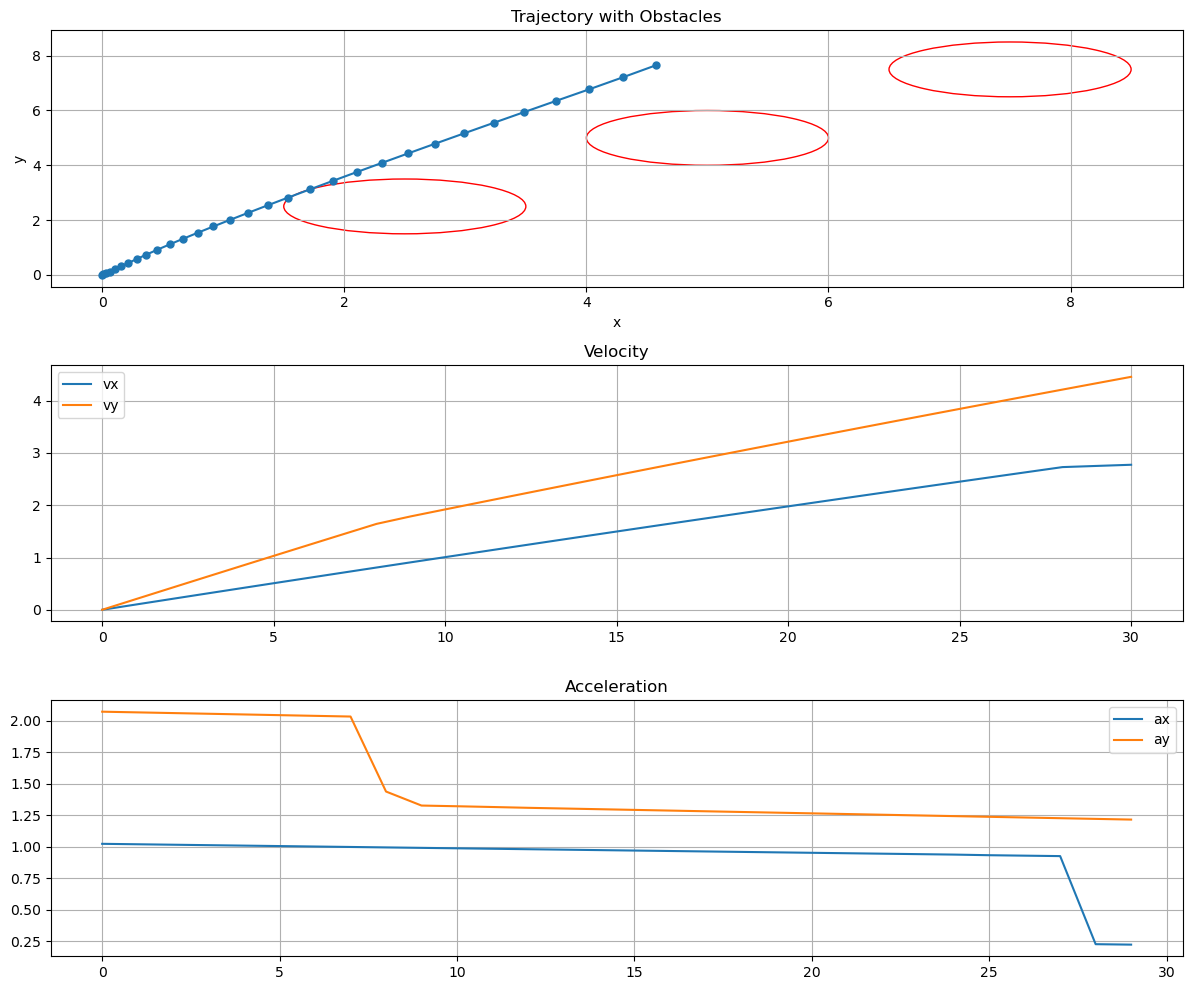

In [183]:
import matplotlib.pyplot as plt

dT = .1

def dynamics(state, action, dT):
    x, y, vel_x, vel_y = state
    a_x, a_y = action

    vel_x += a_x * dT
    vel_y += a_y * dT
    x += vel_x * dT
    y += vel_y * dT

    return np.array( [ x, y, vel_x, vel_y ] )

# Calculate optimal inputs
optimal_actions = np.reshape(optimal_inputs, (-1, 2))
state = initial_state.raw_state()
states = [state]
for action in optimal_actions:
    states.append(dynamics(states[-1], action, dT))

print(states)

# Extracting x, y, vx, vy from states
x = [state[0] for state in states]
y = [state[1] for state in states]
vx = [state[2] for state in states]
vy = [state[3] for state in states]

# Calculating ax and ay
ax = [(vx[i+1] - vx[i]) / dT for i in range(len(vx)-1)]
ay = [(vy[i+1] - vy[i]) / dT for i in range(len(vy)-1)]

# Plotting
plt.figure(figsize=(12, 10))

# Plotting trajectory on a coordinate grid
plt.subplot(3, 1, 1)
plt.plot(x, y, marker='o', linestyle='-', markersize=5)
for obstacle in obstacles:
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='r', fill=False)
    plt.gca().add_patch(circle)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory with Obstacles')
plt.grid(True)

# ax = plt.gca()
# ax.set_aspect('equal', adjustable='box')

plt.subplot(3, 1, 2)
plt.plot(vx, label='vx')
plt.plot(vy, label='vy')
plt.legend()
plt.grid(True)
plt.title('Velocity')

plt.subplot(3, 1, 3)
plt.plot(ax, label='ax')
plt.plot(ay, label='ay')
plt.legend()
plt.grid(True)
plt.title('Acceleration')

plt.tight_layout()
plt.show()